# Geotypicality

A notebook to produce the interactive visualization of authors' geographic usage referenced in Evans and Wilkens, "Nation, Ethnicity, and the Geography of British Fiction, 1880-1940," *Cultural Analytics* (2018). 

See the article and the [output visualization](https://plot.ly/~mattwilkens/119/british-literary-geography-1880-1940/#/) for additional details.

In [1]:
# Imports and parameters
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from   IPython.display import display
from   sklearn.decomposition import PCA
from   sklearn.metrics.pairwise import paired_euclidean_distances
from   sklearn.preprocessing import StandardScaler
import plotly.plotly as py
import plotly.graph_objs as go

# Define colors for use throughout
colors = {
  'Hathi':     'darkblue', 
  'Foreign':   'darkred',
  'London':    'darkgreen',
  'Prominent': 'purple'
 }

# Directories for input and output
figDir     = os.path.join('figures', 'geotyp')
resultsDir = os.path.join('results', 'geotyp')
dataDir    = os.path.join('results', 'publication', 'data')
os.makedirs(figDir, exist_ok=True)
os.makedirs(resultsDir, exist_ok=True)
os.makedirs(dataDir, exist_ok=True)

sns.set()
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

not_in_london = frozenset([    
    'Thames',
    'Thames River',
    'River Thames',
    'Kew Gardens'
])

In [2]:
# Read in data
data = pd.read_csv(os.path.join(dataDir, 'data.tsv.gz'), sep='\t', low_memory=False)
data['occurs_100k'] = data['occurs']*100000/data['wordcount']

# Group the data by corpus and generate subsets to be used below
corpus_grouped        = data.groupby('corpus')
corpus_gb_grouped     = data.loc[(data.country_short=='GB')].groupby('corpus')
corpus_nongb_grouped  = data.loc[(data.country_short!='GB')].groupby('corpus')
corpus_london_grouped = data.loc[(data.country_short == 'GB') &
                                 ((data.admin_2 == 'Greater London') |
                                 (data.text_string.isin(not_in_london)))].groupby('corpus')

# Build dataframe that's just the corpus with metadata, not geo.
# Much smaller than full dataset, useful for some quickies below
metadata = data[['htid', 'corpus','author', 'title', 'pub_date', 
                 'genre', 'gender', 'white', 'origin_area', 'origin_nation',
                 'wordcount'
                ]].drop_duplicates()
metadata_grouped = metadata.groupby('corpus')

print("Unique HTIDs across all corpora:", data.htid.nunique())
print("\nVolumes per corpus:", corpus_grouped.htid.nunique())

Unique HTIDs across all corpora: 10765

Volumes per corpus: corpus
Foreign        130
Hathi        10010
London         171
Prominent      576
Name: htid, dtype: int64


In [3]:
def auth_means(df, target, context, corpus):
    '''
    Display authors with value of target quantity near the mean for corpus.
    '''
    p = df.get_group(corpus)
    p = p.merge(metadata[metadata.corpus==corpus], how='left', left_on='author', right_on='author')
    p = p[[target, 'weight', 'author', 'pub_date', 'gender', 'white', 'origin_area', 'wordcount']].\
        sort_values(target, ascending=False)
    p = p.groupby('author')
    output = []
    for auth, rec in p:
        ethnicity = rec.white.values[0]
        weight = rec.weight.mean()
        target_value = rec[target].mean()
        wc = rec.wordcount.sum()
        vols = rec.wordcount.count()
        pub_date_avg = rec.pub_date.mean()
        output.append((auth, target_value, weight, pub_date_avg, vols, wc, ethnicity, corpus))
    p = pd.DataFrame.from_records(output)
    p.columns = ['author', target, 'weight', 'pub_date_avg', 'books', 'wordcount', 'ethnicity', 'corpus']
    p = p.sort_values(target, ascending=False)
    p.to_csv(os.path.join(resultsDir, target+'_by_auth_'+corpus+'.tsv'), sep='\t')
    mean_target = sum(p[target]*p.weight)/p.weight.sum()
    print("Weighted mean of %s in %s:"%(target, corpus), round(mean_target, 4))
    closest = p.index.get_loc(np.abs(p[target]-mean_target).argmin())
    #display(p.iloc[range(closest-context, closest+context)])
    return p

## International fraction

In [4]:
corpora = list(metadata_grouped.groups.keys())
print(corpora)

['Foreign', 'Hathi', 'London', 'Prominent']


In [5]:
# Build weighted dataframe
output = []
for name, group in corpus_grouped:
    group_occurs = group.occurs_100k.sum()
    group_vols   = group.htid.nunique()
    avg_occurs   = group_occurs/group_vols
    byvol = group.groupby('author')
    for htid, vol in byvol:
        weight = vol.occurs_100k.sum()/avg_occurs
        ethnicity = vol.white.values[0]
        gb_frac = vol.loc[(vol.country_short=='GB')].occurs_100k.sum()/vol.occurs_100k.sum()
        output.append((name, htid, ethnicity, gb_frac, weight))
df = pd.DataFrame.from_records(output)
df.columns = ['corpus', 'author', 'ethnicity', 'gb_frac', 'weight']
df['intl_frac'] = 1 - df.gb_frac

# Group and run tests
intl_frac_authg = df.groupby('corpus')
makenew=True
for c in corpora:
    result = auth_means(intl_frac_authg, 'intl_frac', 10, c)
    # Examine Woolf and Joyce
    #display(result[result.author.isin(['Woolf, Virginia', 'Joyce, James'])])

    # Start building features data for geo-typicality calculation
    if makenew:
        geotyp = result[['corpus', 'author', 'intl_frac']]
        makenew=False
    else:
        geotyp = geotyp.append(result[['corpus', 'author', 'intl_frac']])

Weighted mean of intl_frac in Foreign: 0.8212
Weighted mean of intl_frac in Hathi: 0.7129
Weighted mean of intl_frac in London: 0.433
Weighted mean of intl_frac in Prominent: 0.6264


## Intensity

In [6]:
# Build weighted dataframe
output = []
for name, group in corpus_grouped:
    byvol = group.groupby('author')
    for htid, vol in byvol:
        weight = vol.htid.nunique()
        ethnicity = vol.white.values[0]
        intensity = vol.occurs_100k.sum()/vol.htid.nunique()
        output.append((name, htid, ethnicity, intensity, weight))
df = pd.DataFrame.from_records(output)
df.columns = ['corpus', 'author', 'ethnicity', 'occurs_100k', 'weight']

# Group and run tests
intensity_authg = df.groupby('corpus')
makenew = True
for c in corpora:
    result = auth_means(intensity_authg, 'occurs_100k', 10, c)
    # Examine Woolf and Joyce
    #display(result[result.author.isin(['Woolf, Virginia', 'Joyce, James'])])
    # Add intensity to geotyp frame
    if makenew:
        temp = result[['author', 'occurs_100k', 'corpus']]
        makenew = False
    else:
        temp = temp.append(result[['author', 'occurs_100k', 'corpus']])
geotyp = geotyp.merge(temp, how='left', on=['author', 'corpus'])

Weighted mean of occurs_100k in Foreign: 614.9341
Weighted mean of occurs_100k in Hathi: 280.3757
Weighted mean of occurs_100k in London: 273.0758
Weighted mean of occurs_100k in Prominent: 267.1833


## Specificity: World below city level

In [7]:
print("Specificity world-wide, below city level ...")

# What counts as non-specific
nonspec_subcity = ('administrative_area_level_1',
           'administrative_area_level_2',
           'administrative_area_level_3',
           'administrative_area_level_4',
           'administrative_area_level_5',
           'country',
           'continent',
           'locality',
           'natural_feature'
          )

output = []
for name, group in corpus_grouped:
    group_occurs = group.occurs_100k.sum()
    group_vols   = group.htid.nunique()
    avg_occurs   = group_occurs/group_vols
    for volid, vol in group.groupby('author'):
        weight = vol.occurs_100k.sum()/avg_occurs
        ethnicity = vol.white.values[0]
        spec_frac = vol.loc[(~vol.location_type.isin(nonspec_subcity))].occurs_100k.sum()/vol.occurs_100k.sum()
        output.append((name, volid, ethnicity, spec_frac, weight))
n = pd.DataFrame.from_records(output)
n.columns = ['corpus', 'author', 'ethnicity', 'spec_world_subcity', 'weight']

# Group and run tests
ng = n.groupby('corpus')
makenew = True
for c in corpora:
    result = auth_means(ng, 'spec_world_subcity', 10, c)
    # Examine Woolf and Joyce
    #display(result[result.author.isin(['Woolf, Virginia', 'Joyce, James'])])
    # Add intensity to geotyp frame
    if makenew:
        temp = result[['author', 'spec_world_subcity', 'corpus']]
        makenew = False
    else:
        temp = temp.append(result[['author', 'spec_world_subcity', 'corpus']])
geotyp = geotyp.merge(temp, how='left', on=['author', 'corpus'])

Specificity world-wide, below city level ...
Weighted mean of spec_world_subcity in Foreign: 0.1847
Weighted mean of spec_world_subcity in Hathi: 0.2448
Weighted mean of spec_world_subcity in London: 0.3748
Weighted mean of spec_world_subcity in Prominent: 0.2646


## Specificity: Non-GB below country level

In [8]:
# Different def of nonspecific here
nonspec_subcountry = (
           'country',
           'continent',
           'natural_feature'
          )

output = []
for name, group in corpus_nongb_grouped:
    group_occurs = group.occurs_100k.sum()
    group_vols   = group.htid.nunique()
    avg_occurs   = group_occurs/group_vols
    byvol = group.groupby('author')
    for htid, vol in byvol:
        weight = vol.occurs_100k.sum()/avg_occurs
        ethnicity = vol.white.values[0]
        spec_frac = vol.loc[(~vol.location_type.isin(nonspec_subcountry))].occurs_100k.sum()/vol.occurs_100k.sum()
        output.append((name, htid, ethnicity, spec_frac, weight))
df = pd.DataFrame.from_records(output)
df.columns = ['corpus', 'author', 'ethnicity', 'spec_nongb_subcountry', 'weight']

# Group and run tests
ng = df.groupby('corpus')
makenew = True
for c in corpora:
    result = auth_means(ng, 'spec_nongb_subcountry', 10, c)
    # Examine Woolf and Joyce
    #display(result[result.author.isin(['Woolf, Virginia', 'Joyce, James'])])
    # Add intensity to geotyp frame
    if makenew:
        temp = result[['author', 'spec_nongb_subcountry', 'corpus']]
        makenew = False
    else:
        temp = temp.append(result[['author', 'spec_nongb_subcountry', 'corpus']])
geotyp = geotyp.merge(temp, how='left', on=['author', 'corpus'])

Weighted mean of spec_nongb_subcountry in Foreign: 0.5029
Weighted mean of spec_nongb_subcountry in Hathi: 0.685
Weighted mean of spec_nongb_subcountry in London: 0.6885
Weighted mean of spec_nongb_subcountry in Prominent: 0.6678


## London as fraction of GB

In [9]:
# Add the last feature, London/GB fraction
# Build weighted dataframe
output = []
for name, group in corpus_gb_grouped:
    group_occurs = group.occurs_100k.sum()
    group_vols   = group.htid.nunique()
    avg_occurs   = group_occurs/group_vols
    byvol = group.groupby('author')
    for htid, vol in byvol:
        weight = vol.occurs_100k.sum()/avg_occurs
        ethnicity = vol.white.values[0]
        london_frac = vol.loc[((vol.admin_2=='Greater London') | (vol.text_string.isin(not_in_london)))].occurs_100k.sum()/vol.occurs_100k.sum()
        output.append((name, htid, ethnicity, london_frac, weight))
df = pd.DataFrame.from_records(output)
df.columns = ['corpus', 'author', 'ethnicity', 'london_frac', 'weight']

# Group and run tests
ng = df.groupby('corpus')
makenew = True
for c in corpora:
    result = auth_means(ng, 'london_frac', 10, c)
    # Examine Woolf and Joyce
    #display(result[result.author.isin(['Woolf, Virginia', 'Joyce, James'])])
    # Add intensity to geotyp frame
    if makenew:
        temp = result[['author', 'london_frac', 'corpus']]
        makenew = False
    else:
        temp = temp.append(result[['author', 'london_frac', 'corpus']])
geotyp = geotyp.merge(temp, how='left', on=['author', 'corpus'])

Weighted mean of london_frac in Foreign: 0.4251
Weighted mean of london_frac in Hathi: 0.4041
Weighted mean of london_frac in London: 0.6855
Weighted mean of london_frac in Prominent: 0.464


## Book count

In [10]:
output = []
for name, group in corpus_grouped:
    byauth = group.groupby('author')
    for auth, books in byauth:
        vols = books.htid.nunique()
        weight = 1
        output.append((name, auth, vols, weight))
df = pd.DataFrame.from_records(output)
df.columns = ['corpus', 'author', 'volumes', 'weight']

# Group and run tests
ng = df.groupby('corpus')
makenew = True
for c in corpora:
    result = auth_means(ng, 'volumes', 10, c)
    # Examine Woolf and Joyce
    #display(result[result.author.isin(['Woolf, Virginia', 'Joyce, James'])])
    # Add intensity to geotyp frame
    if makenew:
        temp = result[['author', 'volumes', 'corpus']]
        makenew = False
    else:
        temp = temp.append(result[['author', 'volumes', 'corpus']])
geotyp = geotyp.merge(temp, how='left', on=['author', 'corpus'])

Weighted mean of volumes in Foreign: 2.434
Weighted mean of volumes in Hathi: 2.1573
Weighted mean of volumes in London: 2.1375
Weighted mean of volumes in Prominent: 5.6471


In [11]:
geotyp.fillna(value=0, inplace=True)

In [12]:
geotyp.describe()

,intl_frac,occurs_100k,spec_world_subcity,spec_nongb_subcountry,london_frac,volumes
count,4722.000000,4722.000000,4722.000000,4722.000000,4722.000000,4722.000000
mean,0.714263,300.160185,0.256358,0.690943,0.415946,2.235493
std,0.222758,220.564654,0.132470,0.155327,0.239297,3.991999
min,0.000000,5.786702,0.000000,0.000000,0.000000,1.000000
25%,0.542860,150.513591,0.164737,0.601760,0.237288,1.000000
50%,0.758628,245.120202,0.232335,0.705882,0.400000,1.000000
75%,0.918919,384.723195,0.321776,0.795948,0.566570,2.000000
max,1.000000,2155.349480,0.938776,1.000000,1.000000,72.000000


## Math

-2.24508632307e-16 1.0
(4722, 5)


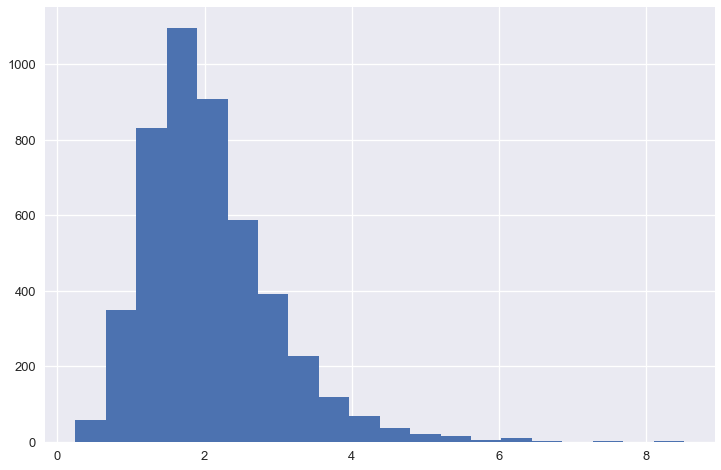

In [13]:
geotyp = geotyp.sort_values(['corpus', 'author'])
corpus_list = geotyp.corpus.tolist()
author_list = geotyp.author.tolist()
bookcounts = geotyp.volumes.tolist()
bookcounts = [int(i) for i in bookcounts]
most_books = max(bookcounts)
typdata = geotyp.iloc[:,2:7].as_matrix()

scaler = StandardScaler()
typ_scaled = scaler.fit_transform(typdata)
print(np.mean(typ_scaled), np.std(typ_scaled))
print(typ_scaled.shape)

distances = paired_euclidean_distances(typ_scaled, np.zeros(typ_scaled.shape))
fig = plt.hist(distances, bins=20)

In [14]:
typ = pd.Series.from_array(distances, index=[corpus_list, author_list])
print("Geotypical authors, from most typical to least")
typ.sort_values().head(10)

Geotypical authors, from most typical to least


Hathi      Keable, Robert,                      0.243997
           Stern, G. B. (Gladys Bronwyn),       0.305803
           Hutchison, William G.,               0.310108
           Montague, C. E. (Charles Edward),    0.311446
           Firbank, Ronald,                     0.331593
           Somerville, E. Œ.                    0.338130
           Treble, H. A.                        0.345683
           Corner, Caroline.                    0.400956
Prominent  Firbank, [Arthur Annesley] Ronald    0.401138
Hathi      Treble, Henry Arthur.                0.409141
dtype: float64

In [15]:
typ.loc['Prominent'].sort_values().head(20)

Firbank, [Arthur Annesley] Ronald    0.401138
West, Rebecca                        0.468818
Aldington, Richard                   0.633435
Huxley, Aldous                       0.638704
Munro, Hector Hugh                   0.646356
Lawrence, D. H.                      0.670664
Conrad, Joseph                       0.679241
Maugham, William Somerset            0.755554
Wilde, Oscar                         0.779494
Macaulay, Rose                       0.783740
Greene, Graham                       0.794918
Ford, Ford Madox                     0.814692
Bowen, Elizabeth                     0.833852
Bentley, E. C.                       0.840442
James, Henry                         0.849743
Isherwood, Christopher               0.895694
Joyce, James                         0.909991
Powell, Anthony                      0.922054
Waugh, Evelyn                        0.924258
Conan Doyle, Arthur                  0.947908
dtype: float64

In [16]:
# Same data, but z-scores rather than raw numbers
#  Note that distance is raw, not z-score
typ_zscores = pd.concat(
    [
        pd.DataFrame(typ_scaled), 
        pd.DataFrame(distances), 
        pd.DataFrame(bookcounts)
    ], 
    axis=1
)
typ_zscores.columns = [
    'intl_frac', 
    'occurs_100k', 
    'world_subcity', 
    'nongb_subcountry', 
    'london_frac', 
    'distance', 
    'volumes'
]
typ_zscores.index = [corpus_list, author_list]
typ_zscores.sort_values('distance', inplace=True)
typ_zscores.head(10)

intl_frac  occurs_100k  \
Hathi     Keable, Robert,                     0.216450    -0.034379   
          Stern, G. B. (Gladys Bronwyn),     -0.139110    -0.103849   
          Hutchison, William G.,              0.020145     0.164111   
          Montague, C. E. (Charles Edward),  -0.008974    -0.167409   
          Firbank, Ronald,                    0.163647     0.208781   
          Somerville, E. Œ.                   0.130332    -0.004447   
          Treble, H. A.                      -0.216614    -0.007589   
          Corner, Caroline.                   0.365959     0.044048   
Prominent Firbank, [Arthur Annesley] Ronald   0.245509     0.098186   
Hathi     Treble, Henry Arthur.              -0.210674    -0.006646   

                                             world_subcity  nongb_subcountry  \
Hathi     Keable, Robert,                        -0.076337         -0.029146   
          Stern, G. B. (Gladys Bronwyn),          0.223005          0.115438   
          Hutchison, William G.,                 -0.189560          0.086310   
          Montague, C. E. (Charles Edward),      -0.190450         -0.142094   
          Firbank, Ronald,                       -0.023689          0.197401   
          Somerville, E. Œ.                       0.286396          0.071137   
          Treble, H. A.                           0.084707         -0.124838   
          Corner, Caroline.                      -0.074586         -0.032851   
Prominent Firbank, [Arthur Annesley] Ronald      -0.022528          0.300211   
Hathi     Treble, Henry Arthur.                   0.241200         -0.130371   

                                             london_frac  distance  volumes  
Hathi     Keable, Robert,                      -0.069466  0.243997        6  
          Stern, G. B. (Gladys Bronwyn),        0.017939  0.305803       11  
          Hutchison, William G.,               -0.159519  0.310108        1  
          Montague, C. E. (Charles Edward),     0.111492  0.311446        1  
          Firbank, Ronald,                      0.007451  0.331593        9  
          Somerville, E. Œ.                    -0.101207  0.338130       11  
          Treble, H. A.                        -0.223064  0.345683        1  
          Corner, Caroline.                     0.135117  0.400956        1  
Prominent Firbank, [Arthur Annesley] Ronald     0.019038  0.401138       10  
Hathi     Treble, Henry Arthur.                -0.218621  0.409141        1

## Visualization

In [17]:
# Reduce dimensionality
num_dims = 2
pca = PCA(n_components=num_dims)
compute_reduced = pca.fit_transform(typ_scaled)
for i in range(1,num_dims+1):
    pctvar = sum(pca.explained_variance_ratio_[0:i])
    print("(%s) Sum of variance explained: %s" % (i, pctvar))
# Loadings
# Get PC loadings
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, index=typ_zscores.columns[:5])

# show top n load items for first 10 PCs
print("Loadings:")
display(loadings_df)

(1) Sum of variance explained: 0.327104421445
(2) Sum of variance explained: 0.533593304992
Loadings:


,0,1
intl_frac,0.278234,-0.603692
occurs_100k,0.446459,-0.378884
world_subcity,-0.597458,-0.262163
nongb_subcountry,-0.501829,-0.570508
london_frac,-0.338335,0.312721


In [18]:
plotdata = pd.DataFrame(compute_reduced, index=[corpus_list, author_list])
plotdata.columns=['PC1', 'PC2']
plotdata = plotdata.merge(typ_zscores, how='left', left_index=True, right_index=True)
plotdata.index = plotdata.index.set_names(['corpus', 'author'])
plotdata.reset_index(inplace=True)

In [19]:
plotdata['label'] = plotdata.author + ' (' + \
                    plotdata.volumes.apply(str) + ' vols) ' + \
                    round(plotdata.distance, 2).apply(str) + '<br>' + \
                    'International %: ' + round(plotdata.intl_frac, 2).apply(str) + '<br>' + \
                    'Mentions/100k: ' + round(plotdata.occurs_100k, 2).apply(str) + '<br>' + \
                    'Global subcity %: ' + round(plotdata.world_subcity, 2).apply(str) + '<br>' + \
                    'Non-GB subcountry %: ' + round(plotdata.nongb_subcountry, 2).apply(str) + '<br>' + \
                    'London/GB %: ' + round(plotdata.london_frac, 2).apply(str)
plotdata.head()

,corpus,author,PC1,PC2,intl_frac,occurs_100k,world_subcity,nongb_subcountry,london_frac,distance,volumes,label
0,Foreign,"Ali, Ahmed",0.101855,-0.904247,1.139574,-0.458467,-0.329109,0.645582,-0.345268,1.467351,1,"Ali, Ahmed (1 vols) 1.47<br>International %: 1..."
1,Foreign,"Ali, Mohomed Duse",5.064223,-1.153943,0.534191,5.582349,-1.458856,-2.257826,-1.237389,6.340753,1,"Ali, Mohomed Duse (1 vols) 6.34<br>Internation..."
2,Foreign,"Anand, Mulk Raj",0.715623,-0.144124,0.792578,0.149212,0.013065,-0.771084,-0.145822,1.125367,10,"Anand, Mulk Raj (10 vols) 1.13<br>Internationa..."
3,Foreign,"Azikiwe, Benjamin Nnamdi",3.640428,-0.887768,0.988956,3.648904,-0.412990,-2.281802,-1.017806,4.550346,1,"Azikiwe, Benjamin Nnamdi (1 vols) 4.55<br>Inte..."
4,Foreign,"Baijnath, Lala",3.685660,0.219612,-0.513710,4.237920,-0.958198,-2.440915,-0.411214,5.026845,1,"Baijnath, Lala (1 vols) 5.03<br>International ..."


In [20]:
# Interactive plot
l = []
N = plotdata.corpus.nunique()
biggest_bubble = plotdata.volumes.max()

for c in corpora:
    if c == 'Hathi':
        opac = 0.02
    else:
        opac = 0.4
    labels = plotdata[plotdata.corpus == c].label.tolist()
    bookcounts = plotdata[plotdata.corpus == c].volumes.tolist()
    trace0= go.Scattergl(
        x= plotdata[plotdata.corpus == c]['PC1'],
        y= plotdata[plotdata.corpus == c]['PC2'],
        mode= 'markers',
        marker= dict(size= bookcounts,
                     sizemode='area',
                     sizeref=2.*biggest_bubble/(75.**2),
                     line= dict(width=0),
                     color= colors[c],
                     opacity= opac
                   ),name= c,
        text= labels # The hover text goes here... 
    )
    l.append(trace0);

layout= go.Layout(
    title= 'British literary geography, 1880-1940',
    hovermode= 'closest',
    xaxis= dict(
        title= "PC1: more international, more intensive, less specific, less London →",
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= "PC2: more London, less international, less intensive, less specific →",
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)
fig= go.Figure(data=l, layout=layout)
py.iplot(fig, filename='geotyp multi')

In [21]:
py.image.save_as(fig, filename=os.path.join(figDir, 'geotyp.png'), scale=10)